# Ball Challenge

In [1]:
from typing import cast
from pathlib import Path
from functools import partial

import torch
from torch.nn.functional import softmax
from torch.utils.data import Dataset, random_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

from elasticai.creator.nn import Sequential
from elasticai.creator.file_generation.on_disk_path import OnDiskPath
from elasticai.creator.vhdl.system_integrations.firmware_env5 import FirmwareENv5

from ballchallenge.model_builder import ModelBuilder
from ballchallenge.accelerometer_dataset import AccelerometerDataset
from ballchallenge.training import run_training


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_ROOT = Path("../data")
GRID_SIZE = (10, 10)

## Load Training and Test Data

In [2]:
def load_dataset() -> AccelerometerDataset:
    def flat_labels(labels: torch.Tensor) -> torch.Tensor:
        return labels.flatten(start_dim=1)

    def downsample(samples: torch.Tensor, factor: int) -> torch.Tensor:
        return samples[:,:,::factor]

    return AccelerometerDataset(
        dataset_root=DATASET_ROOT,
        grid_size=GRID_SIZE,
        x_position_range=(0, 2),
        y_position_range=(0, 2),
        label_std=0.3,
        transform_samples=partial(downsample, factor=4),
        transform_labels=flat_labels,
    )

ds = load_dataset()
ds_train, ds_test = random_split(ds, lengths=[0.75, 0.25], generator=torch.Generator().manual_seed(42))

print("Train Samples:", len(ds_train))
print("Test Samples:", len(ds_test))

input_shape = cast(tuple[int, int], tuple(ds_train[:][0].shape[1:]))
print("Sample Shape:", input_shape)

Train Samples: 15
Test Samples: 4
Sample Shape: (3, 250)


## Create Model

In [3]:
def build_model(input_shape: tuple[int, int]) -> Sequential:
    model_builder = ModelBuilder(total_bits=8, frac_bits=4, input_shape=input_shape)
    
    model_builder.add_conv1d(filters=1, kernel_size=64).add_hard_tanh()
    model_builder.add_conv1d(filters=1, kernel_size=64).add_hard_tanh()
    model_builder.add_conv1d(filters=1, kernel_size=96).add_hard_tanh()
    model_builder.add_flatten()
    model_builder.add_linear(output_units=GRID_SIZE[0] * GRID_SIZE[1])

    return model_builder.build_model()

model = build_model(input_shape)
print("Model Parameters:", sum(param.numel() for param in model.parameters()))

Model Parameters: 3355


## Train Model

In [4]:
history = run_training(
    model=model,
    ds_train=ds_train,
    ds_test=ds_test,
    batch_size=8,
    epochs=300,
    learning_rate=5e-4,
    device=DEVICE
)

model.eval()
model.to("cpu")

[epoch 1/300] train_loss: 0.2415 ; test_loss: 0.2488
[epoch 2/300] train_loss: 0.2409 ; test_loss: 0.2488
[epoch 3/300] train_loss: 0.2417 ; test_loss: 0.2488
[epoch 4/300] train_loss: 0.2413 ; test_loss: 0.2488
[epoch 5/300] train_loss: 0.2409 ; test_loss: 0.2487
[epoch 6/300] train_loss: 0.2407 ; test_loss: 0.2487
[epoch 7/300] train_loss: 0.2411 ; test_loss: 0.2486
[epoch 8/300] train_loss: 0.2411 ; test_loss: 0.2481
[epoch 9/300] train_loss: 0.2408 ; test_loss: 0.2475
[epoch 10/300] train_loss: 0.2401 ; test_loss: 0.2471
[epoch 11/300] train_loss: 0.2391 ; test_loss: 0.2468
[epoch 12/300] train_loss: 0.2386 ; test_loss: 0.2456
[epoch 13/300] train_loss: 0.2376 ; test_loss: 0.2449
[epoch 14/300] train_loss: 0.2369 ; test_loss: 0.2441
[epoch 15/300] train_loss: 0.2364 ; test_loss: 0.2427
[epoch 16/300] train_loss: 0.2346 ; test_loss: 0.2422
[epoch 17/300] train_loss: 0.2337 ; test_loss: 0.2410
[epoch 18/300] train_loss: 0.2324 ; test_loss: 0.2392
[epoch 19/300] train_loss: 0.2308 ; t

_InputQuantizedSequential(
  (0): Conv1d(3, 1, kernel_size=(64,), stride=(1,))
  (1): HardTanh(min_val=-1, max_val=1)
  (2): Conv1d(1, 1, kernel_size=(64,), stride=(1,))
  (3): HardTanh(min_val=-1, max_val=1)
  (4): Conv1d(1, 1, kernel_size=(96,), stride=(1,))
  (5): HardTanh(min_val=-1, max_val=1)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=29, out_features=100, bias=True)
)

## Evaluate Trained Model

### Training History

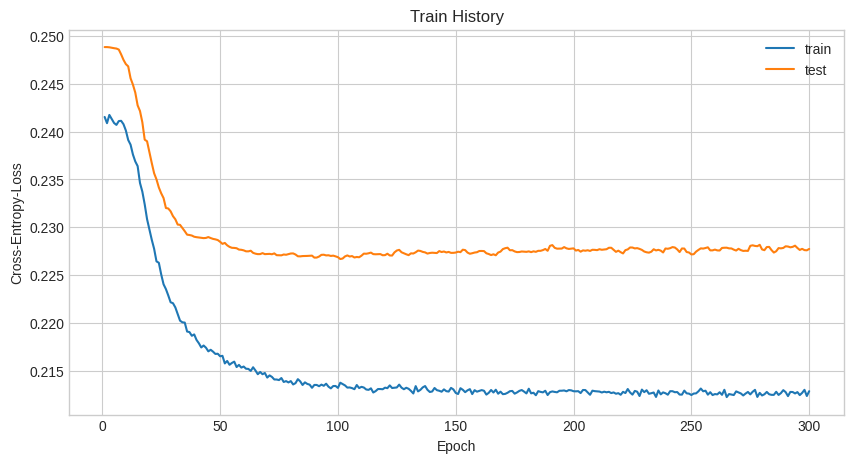

In [5]:
def plot_training_history() -> None:
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    ax.plot(history.train["epoch"], history.train["loss"], label="train")
    ax.plot(history.test["epoch"], history.test["loss"], label="test")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Cross-Entropy-Loss")
    ax.set_title("Train History")
    ax.legend()

plot_training_history()

### Show Predictions

In [6]:
def render_target_and_prediction(dataset: Dataset, sample_idx: int):
    sample, target = dataset[sample_idx]
    prediction = softmax(model(sample).detach(), dim=1).view(*GRID_SIZE[::-1])
    target = target.view(*GRID_SIZE[::-1])
    
    _, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    sns.heatmap(prediction, cmap="hot", square=True, ax=axs[0])
    axs[0].set_title("Prediction")
    sns.heatmap(target, cmap="hot", square=True, ax=axs[1])
    axs[1].set_title("Target")

#### On Training Set

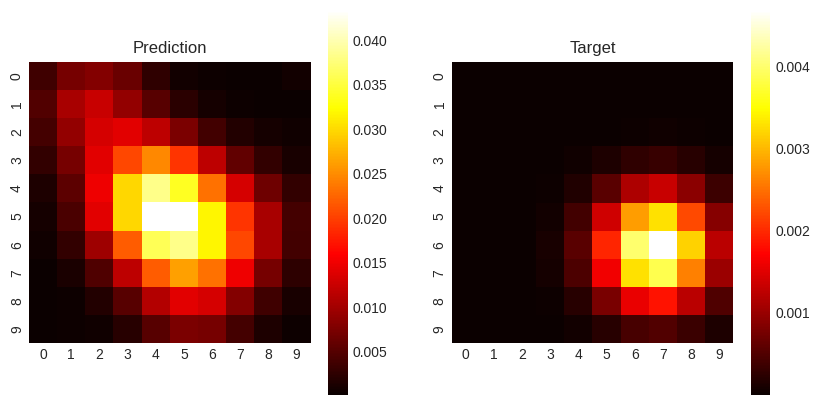

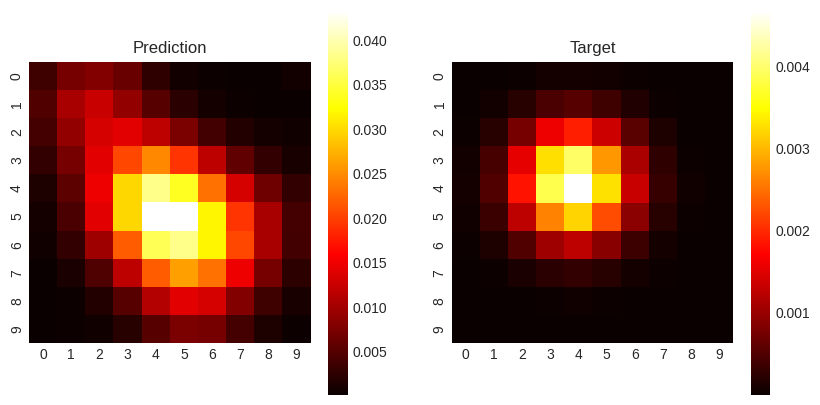

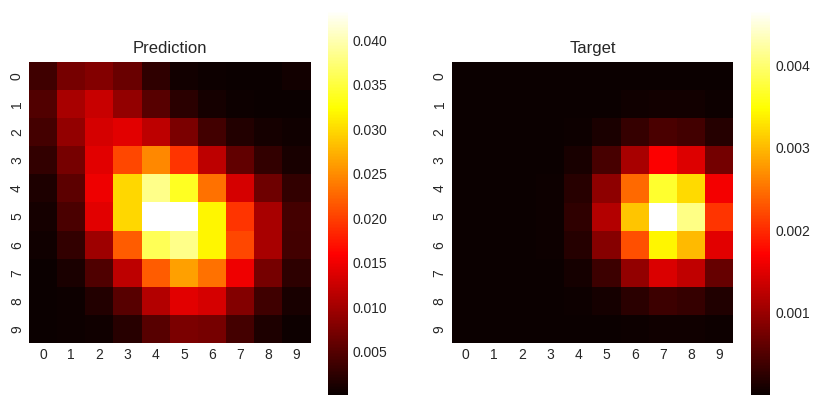

In [7]:
for i in range(3):
    render_target_and_prediction(ds_train, sample_idx=i)

#### On Testing Set

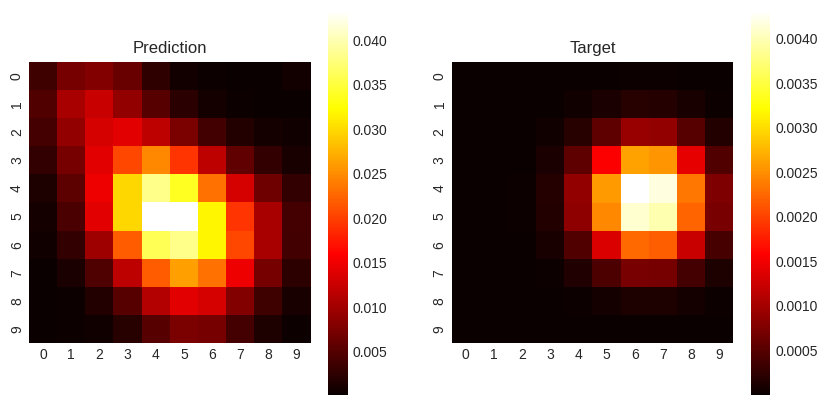

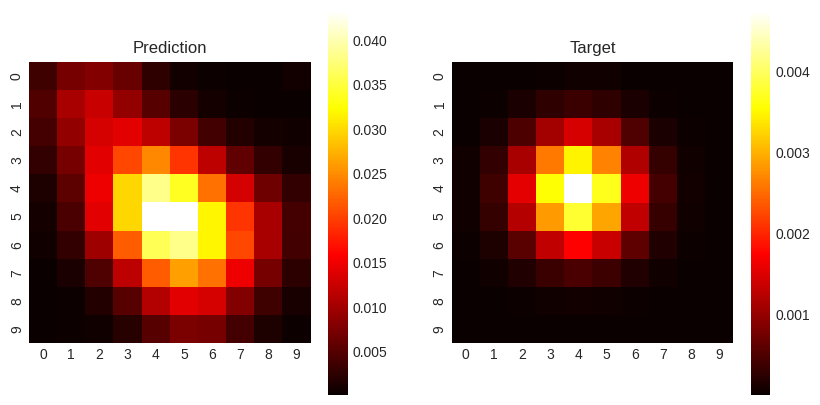

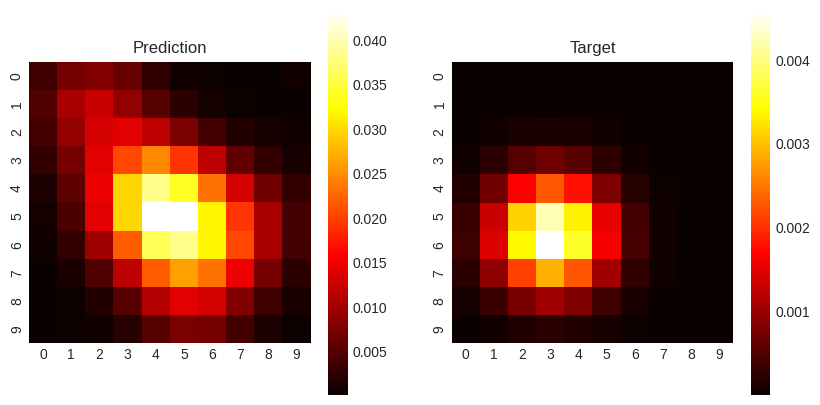

In [8]:
for i in range(3):
    render_target_and_prediction(ds_test, sample_idx=i)

## Save Hardware Implementation

In [9]:
hw_design = model.create_design("ball_throw")

path = OnDiskPath("build")

channels, signal_length = ds_train[0][0].shape
total_length = channels * signal_length
firmware = FirmwareENv5(hw_design, x_num_values=total_length,
                        y_num_values=GRID_SIZE[0]*GRID_SIZE[1], skeleton_version="v2", id=666)

firmware.save_to(path)

## Additional Section

### Mean Label of the Dataset

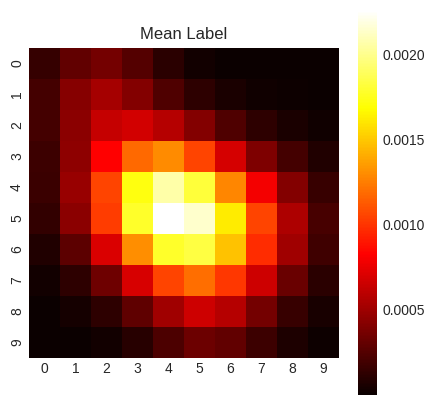

In [10]:
def plot_dataset_mean_label() -> None:
    _, labels = ds[:]
    mean_label = labels.mean(dim=0)
    
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    sns.heatmap(mean_label.view(GRID_SIZE), square=True, cmap="hot", ax=ax)
    ax.set_title("Mean Label")
    

plot_dataset_mean_label()